### 선형회귀기반 분류 알고리즘 학습 - LogisticRegression + 교차검증

- 이진분류 및 다중분류 가능
- 분류지만 선형회귀식기반의 알고리즘이라서 Regresion

[1] 모듈 로딩 및 데이터 준비 

In [217]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
                                    #쪼개기
from sklearn.linear_model import LogisticRegression
                                    #로지스틱회귀
import matplotlib.pyplot as plt

#### [1] 데이터 준비 및 확인

In [218]:
filename='../data/iris.csv'

In [219]:
## 데이터 로딩
irisDF= pd.read_csv(filename)

In [220]:
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa


- 2개 품종만 추출 .'Setosa', 'Versicolor',

In [221]:
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [222]:
# boolean indedxing
dataDF=irisDF[irisDF.variety != 'Virginica'].copy()

dataDF.shape

(100, 5)

In [223]:
dataDF.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


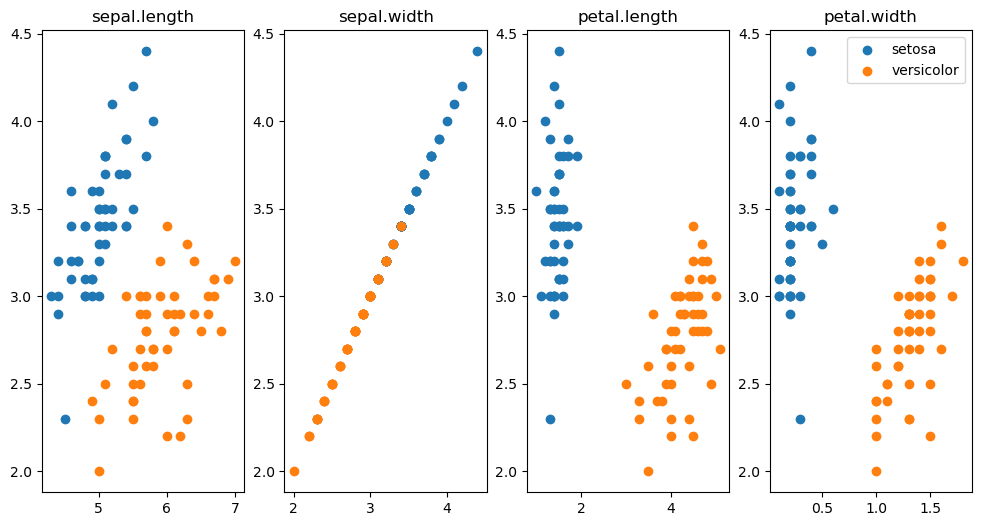

In [224]:
# 2개 품종 식별 가능한 피쳐 선택.
fig, axe = plt.subplots(1,4, figsize=(12,6))
axe = axe.flatten()
s_mask = dataDF[dataDF['variety']=='Setosa']
v_mask = dataDF[dataDF['variety']=='Versicolor']

for ax, i in zip(axe, dataDF.columns[0:4]):
    ax.scatter(s_mask[i], s_mask['sepal.width'], label='setosa')
    ax.scatter(v_mask[i], v_mask['sepal.width'], label='versicolor')
    ax.set_title(i)


# plt.scatter(s_mask['petal.length'], s_mask['petal.width'], label='setosa')
# plt.scatter(v_mask['petal.length'], v_mask['petal.width'], label='versicolor')

plt.legend()
plt.show()

- 꽃잎의 길이와 너비(petal.length, petal.width) 특성만 추출

In [225]:
dataDF.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

In [226]:
dataDF=dataDF[dataDF.columns[2:]].copy()

In [227]:
dataDF.shape
#각 50개씩 있음.

(100, 3)

In [228]:
dataDF.head(3)

,petal.length,petal.width,variety
0,1.4,0.2,Setosa
1,1.4,0.2,Setosa
2,1.3,0.2,Setosa


In [229]:
## 품종컬럼 문자열  ==> 수치형태 변환한 컬럼 추가

labelToNum={'Setosa' : 0, 'Versicolor':1}
dataDF['variety_no']=dataDF.variety.replace(labelToNum )

C:\Users\kdt\AppData\Local\Temp\ipykernel_22188\2792494946.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataDF['variety_no']=dataDF.variety.replace(labelToNum )


In [230]:
dataDF.head(3)

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0


In [231]:
dataDF.corr(numeric_only=True)

,petal.length,petal.width,variety_no
petal.length,1.000000,0.979322,0.969990
petal.width,0.979322,1.000000,0.960307
variety_no,0.969990,0.960307,1.000000


In [232]:
dataDF = dataDF[dataDF.columns[0:]]
dataDF

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0
3,1.5,0.2,Setosa,0
4,1.4,0.2,Setosa,0
...,...,...,...,...
95,4.2,1.2,Versicolor,1
96,4.2,1.3,Versicolor,1
97,4.3,1.3,Versicolor,1
98,3.0,1.1,Versicolor,1


#### [2] 데이터 가공

- 피쳐/특성/독립과 타겟/클래스/종속변수 분리

In [233]:
featureDF = dataDF[dataDF.columns[:2]]
classDF = dataDF.variety_no

In [234]:
dataDF

,petal.length,petal.width,variety,variety_no
0,1.4,0.2,Setosa,0
1,1.4,0.2,Setosa,0
2,1.3,0.2,Setosa,0
3,1.5,0.2,Setosa,0
4,1.4,0.2,Setosa,0
...,...,...,...,...
95,4.2,1.2,Versicolor,1
96,4.2,1.3,Versicolor,1
97,4.3,1.3,Versicolor,1
98,3.0,1.1,Versicolor,1


In [235]:
print(f'featureDF : {featureDF.shape}  classDF : {classDF.shape}')

featureDF : (100, 2)  classDF : (100,)


- 훈련용/테스트용 분리

In [236]:
## - 회귀가 아니고 분류 시행시에는
## 훈련용이랑 테스트용에 동일한 비율로 
## 타겟이 배분되어야 한다.
## setosa : versi = 5:5
#  ==> stratify 매개변수: 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리.
# pytorch엔 없음.

train_X, test_X, train_y, test_y = train_test_split(featureDF, classDF,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=classDF)
print(f"train_X => {train_X.ndim}D {train_X.shape} / test_X => {test_X.ndim}D, {test_X.shape}")
print(f"train_y => {train_y.ndim}D {train_y.shape}, / test_y => {test_y.ndim}D, {test_y.shape}")
    


train_X => 2D (80, 2) / test_X => 2D, (20, 2)
train_y => 1D (80,), / test_y => 1D, (20,)


In [237]:
## 데이터셋별로 클래스 갯수 확인
test_y.value_counts(), train_y.value_counts()

(variety_no
 1    10
 0    10
 Name: count, dtype: int64,
 variety_no
 1    40
 0    40
 Name: count, dtype: int64)

- 특성/피쳐 2개에 대한 스케일링 진행

In [238]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

In [239]:
## StandardScaler : 평균 0, 표준편차 1 즉, 정규분포 따르도록 스케일링.
## 훈련용 DS 기반 스케일러는 테스트용 DS, 사용자 데이터에 대해서 스케일링 진행함.
## 


scaler = StandardScaler()

scaler.fit(train_X)

StandardScaler()

In [240]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 . abd_
## 후행.

print(scaler.var_, scaler.mean_, scaler.feature_names_in_)

[2.12549375 0.32415   ] [2.8725 0.79  ] ['petal.length' 'petal.width']


In [241]:
# 훈련데이터와 테스트 데이터 스케일링 진행
# ==> 훈련용 생성한 스케일러로 훈련용, 테스트용 변환 진행 
# ==> 향후 임의의 새로운 데이터 예측(predict)시에도 해당 스케일러 적용
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : 선형모델 로지스틱회귀 => 
            선형회귀 선형식 ==> 확률로 변환.:sigmoid(선형식)

In [242]:
## 모듈로딩
# 알고리즘 모델
from sklearn.linear_model import LogisticRegression

# 모델 성능평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# 손실계산 
from sklearn.metrics import log_loss


In [243]:
# [3-1] 학습
lmodel = LogisticRegression()
lmodel.fit(train_scaled_X, train_y)

LogisticRegression()

In [244]:
## - 모델 파라미터
print(lmodel.coef_, lmodel.n_features_in_)
print(lmodel.intercept_)
print(lmodel.classes_)

[[2.03218022 1.8833978 ]] 2
[0.25012681]
[0 1]


In [245]:
x = train_scaled_X

In [246]:
lmodel.coef_

array([[2.03218022, 1.8833978 ]])

In [ ]:
# y= w1 x1 + w2 x2 + b
x = train_scaled_X
w = lmodel.coef_[0]
y = w[0]*x[:,0] + w[1]*x[:,1] + lmodel.intercept_

## y를 뽑아주는 메서드 decision_function()
y2 = lmodel.decision_function(x)

y3 = np.dot(x, w) + lmodel.intercept_

print(y[0:5])
print(y2[0:5])
print(y3[0:5])

[ 2.23992221 -1.52361374  2.79748309 -1.10544308  2.65809287]
[ 3.92701598 -3.47534967  4.81537956 -3.05717901  5.00679204]
[ 3.92701598 -3.47534967  4.81537956 -3.05717901  5.00679204]


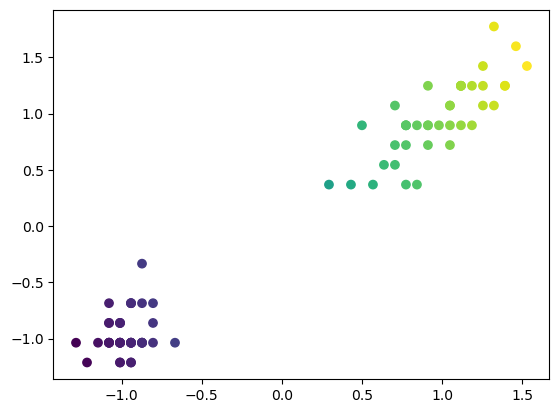

In [80]:
plt.scatter(x[:,0], x[:,1], c=y)

In [ ]:
## -선형식 ==> 확률로 변환
from scipy.special import expit

# 양성일 확률. positive.
one_p = expit(y)
zero_p = 1 - one_p
total_p = np.concatenate([one_p, zero_p])

# ==> predict_proba() 가 하는 일. 
# total_p를 만들어줌.
lmodel.predict_proba(train_scaled_X)


[0.9177214  0.09432604 0.95487251 0.13660823 0.95236764 0.07698358
 0.90656465 0.07698358 0.07305359 0.88012476 0.90656465 0.97131975
 0.04317895 0.07885841 0.9456305  0.93301269 0.06930916 0.82481932
 0.9364675  0.08307268 0.1150882  0.9456305  0.07305359 0.97758013
 0.06415831 0.06764469 0.09432604 0.96051226 0.1266453  0.09657903
 0.06415831 0.68344576 0.09432604 0.95830676 0.06764469 0.09432604
 0.79037936 0.09657903 0.06415831 0.10944363 0.07885841 0.88012476
 0.96812716 0.93301269 0.05628039 0.08307268 0.06930916 0.87401829
 0.9456305  0.74047391 0.89406969 0.94427315 0.9614902  0.91967045
 0.96812716 0.07305359 0.85464154 0.08307268 0.09657903 0.04558083
 0.12378703 0.92765228 0.86815857 0.92189882 0.89931621 0.10692606
 0.8711168  0.07484047 0.07305359 0.88012476 0.08307268 0.97630439
 0.08307268 0.07885841 0.06415831 0.07305359 0.80784242 0.9456305
 0.85136967 0.84405794 0.0822786  0.90567396 0.04512749 0.86339177
 0.04763236 0.92301642 0.09343535 0.92301642 0.92694641 0.11987

array([[0.01932169, 0.98067831],
       [0.9699782 , 0.0300218 ],
       [0.008039  , 0.991961  ],
       [0.95509145, 0.04490855],
       [0.00664785, 0.99335215],
       [0.98102625, 0.01897375],
       [0.02214768, 0.97785232],
       [0.98102625, 0.01897375],
       [0.97711517, 0.02288483],
       [0.0290616 , 0.9709384 ],
       [0.02214768, 0.97785232],
       [0.00187367, 0.99812633],
       [0.98676662, 0.01323338],
       [0.96842567, 0.03157433],
       [0.00763459, 0.99236541],
       [0.01216192, 0.98783808],
       [0.97242055, 0.02757945],
       [0.07119611, 0.92880389],
       [0.0146899 , 0.9853101 ],
       [0.97378196, 0.02621804],
       [0.95280655, 0.04719345],
       [0.00763459, 0.99236541],
       [0.97711517, 0.02288483],
       [0.00238886, 0.99761114],
       [0.98003329, 0.01996671],
       [0.9834541 , 0.0165459 ],
       [0.9699782 , 0.0300218 ],
       [0.00700035, 0.99299965],
       [0.89586848, 0.10413152],
       [0.95041142, 0.04958858],
       [0.

[4] 성능평가

In [175]:
## 훈련용 성능과 테스트용 성능평가
## [1] 모델의 성능평과 
from _utils import tools as ts

score_test1 = lmodel.score(test_scaled_X, test_y)
score_test2 = lmodel.score(train_scaled_X, train_y)
score_test2, score_test1

(1.0, 1.0)

In [180]:
## [2] 다양한 성능평가 지표
pre_ = lmodel.predict(train_scaled_X)
accuracy = accuracy_score(train_y, pre_)
precision = precision_score(train_y, pre_)
recall = recall_score(train_y,pre_)
f1 = f1_score(train_y,pre_)

print('Train')
print(f"정확도 : {accuracy}")
print(f"정밀도 : {precision}")
print(f"재현율 : {recall}")
print(f"f1 : {f1}")

Train
정확도 : 1.0
정밀도 : 1.0
재현율 : 1.0
f1 : 1.0


In [181]:
## [2] 다양한 성능평가 지표
pre_ = lmodel.predict(test_scaled_X)
accuracy = accuracy_score(test_y, pre_)
precision = precision_score(test_y, pre_)
recall = recall_score(test_y,pre_)
f1 = f1_score(test_y,pre_)

print('test')
print(f"정확도 : {accuracy}")
print(f"정밀도 : {precision}")
print(f"재현율 : {recall}")
print(f"f1 : {f1}")

test
정확도 : 1.0
정밀도 : 1.0
재현율 : 1.0
f1 : 1.0


In [ ]:
## [3] 손실/비용 계산 => 확률값으로
proba = lmodel.predict_proba(train_scaled_X)
probatest = lmodel.predict_proba(test_scaled_X)

train_loss = log_loss(train_y, proba)
test_loss = log_loss(test_y, probatest)


In [184]:
print(f"[Train Loss]: {train_loss}")
print(f"[Testn Loss]: {test_loss}")

[Train Loss]: 0.03213373711906877
[Testn Loss]: 0.05160227004900856


In [254]:
## 튜닝닝
## 모듈로딩
## 간편한 교차검증용 함수들 
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import cross_validate 


In [261]:
## - CVcross validate 후 scroe 만 확인
## cv = cv만큼 등분함. kfold의 k default 5
## scoring = default accuracy
##            기타 평가 함수.
cross_val_score(lmodel, train_scaled_X, train_y, cv = 3, scoring='recall')


array([1., 1., 1.])

In [270]:
train_scaled_X.shape

(80, 2)

In [273]:
## cv 후 predict 결과만 반환
## 스코어랑 다르게 최종 모델로 최종 결과 반환.
pred = cross_val_predict(lmodel, train_scaled_X, train_y)
pred[:3]


array([1, 0, 1])

In [272]:
pred = cross_val_predict(lmodel, train_scaled_X, train_y, method='predict_proba')
pred[:3]

array([[0.02190101, 0.97809899],
       [0.96422758, 0.03577242],
       [0.00944524, 0.99055476]])

In [276]:
result = cross_validate(lmodel, train_scaled_X, train_y)
result

{'fit_time': array([0.00353336, 0.00204945, 0.        , 0.00200605, 0.00201416]),
 'score_time': array([0.00100446, 0.        , 0.00590944, 0.        , 0.        ]),
 'test_score': array([1., 1., 1., 1., 1.])}

In [280]:
result = cross_validate(lmodel, train_scaled_X, train_y, return_estimator=True, return_train_score=True)
result

{'fit_time': array([0.00099874, 0.004071  , 0.00207663, 0.        , 0.00733495]),
 'score_time': array([0.00100207, 0.00071502, 0.00108695, 0.        , 0.        ]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_score': array([1., 1., 1., 1., 1.]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [282]:
best_estimator = result['estimator'][0]

In [ ]:
# CV 의 결과를 평균
# 적합상태 파악. 튜닝이 필요여부 확인.

print(sum(result['test_score'])/5, sum(result['train_score'])/5)
print(result['test_score'].mean(), result['train_score'].mean())

1.0 1.0
1.0 1.0


[2] 교차검증 + 튜닝
- 모델별 하이퍼파라미터를 조합해서 모델 인스턴스 생성
- 모델 인스턴스별 CV를 진행
- 시간이 많이 걸림

In [287]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [320]:
## 하이퍼파라미터 dict
# param = {'penalty': ['l1', 'l2', 'elasticnet', None], 'solver':['sag']}
#  error_score='raise'.

param = {'penalty': ['l1'], 'solver':['liblinear']}
# param = {'penalty': ['l2'], 'solver':['liblinear']}
# param = {'penalty': ['l2',  None]}

# 패널티와  solver의 조합 찾기.


## 모델 인스턴스 생성
lmodel = LogisticRegression()

## 교차검증고 ㅏ튜닝 진행 인스턴스 생성
gridCV = GridSearchCV(lmodel, param, scoring=('accuracy'), refit=True, error_score='raise')

In [321]:
gridCV.fit(train_scaled_X, train_y)

GridSearchCV(error_score='raise', estimator=LogisticRegression(),
             param_grid={'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='accuracy')

In [323]:
print(gridCV.best_index_)

0


In [324]:
gridCV.cv_results_

{'mean_fit_time': array([0.00060248]),
 'std_fit_time': array([0.00049193]),
 'mean_score_time': array([0.00085449]),
 'std_score_time': array([0.00043195]),
 'param_penalty': masked_array(data=['l1'],
              mask=[False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['liblinear'],
              mask=[False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l1', 'solver': 'liblinear'}],
 'split0_test_score': array([1.]),
 'split1_test_score': array([1.]),
 'split2_test_score': array([1.]),
 'split3_test_score': array([1.]),
 'split4_test_score': array([1.]),
 'mean_test_score': array([1.]),
 'std_test_score': array([0.]),
 'rank_test_score': array([1], dtype=int32)}

In [325]:
## 교차 검증 및 튜닝 후 결과
print(f" 가장 좋은 성능의 cv번호: {gridCV.best_index_}")
print(f" 가장 좋은 성능의 하이퍼 파라미터 조합:  {gridCV.best_params_}")
print(f" 가장 좋은 성능의 점수: {gridCV.best_score_}")
print(f" 가장 좋은 성능의 재학습된 모델객체:  {gridCV.best_estimator_}")


 가장 좋은 성능의 cv번호: 0
 가장 좋은 성능의 하이퍼 파라미터 조합:  {'penalty': 'l1', 'solver': 'liblinear'}
 가장 좋은 성능의 점수: 1.0
 가장 좋은 성능의 재학습된 모델객체:  LogisticRegression(penalty='l1', solver='liblinear')


In [326]:
## 가장 좋은 모델 선정
bestModel = gridCV.best_estimator_

bestModel.fit(train_scaled_X, train_y)

LogisticRegression(penalty='l1', solver='liblinear')

#### [ 사용자 입력 데이터에 예측]

In [328]:
train_X.head()

,petal.length,petal.width
74,4.3,1.3
29,1.6,0.2
63,4.7,1.4
24,1.9,0.2
54,4.6,1.5


In [ ]:
## 사용자 입력 데이터. == 모델 데이터 형태.
user_data = [[4.5, 9.3]]

## 모델에서 사용하는 scaler, encoder 적용
user_data = scaler.transform(user_data)

c:\Users\kdt\anaconda3\envs\ML_PY39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 1.11632611, 14.94708648]])

array([[ 0.97914317,  0.89577134],
       [-0.8728264 , -1.03628449],
       [ 1.25350904,  1.07141278],
       [-0.667052  , -1.03628449],
       [ 1.18491757,  1.24705422],
       [-0.94141787, -1.21192593],
       [ 0.91055171,  0.89577134],
       [-0.94141787, -1.21192593],
       [-1.01000933, -1.03628449],
       [ 0.77336878,  0.89577134],
       [ 0.91055171,  0.89577134],
       [ 1.3221005 ,  1.77397854],
       [-1.2843752 , -1.03628449],
       [-1.01000933, -0.86064305],
       [ 1.11632611,  1.24705422],
       [ 1.04773464,  1.07141278],
       [-1.0786008 , -0.86064305],
       [ 0.63618585,  0.54448846],
       [ 1.11632611,  0.89577134],
       [-0.94141787, -1.03628449],
       [-0.80423494, -0.86064305],
       [ 1.11632611,  1.24705422],
       [-1.01000933, -1.03628449],
       [ 1.5278749 ,  1.42269566],
       [-1.0786008 , -1.03628449],
       [-1.01000933, -1.21192593],
       [-0.8728264 , -1.03628449],
       [ 1.3221005 ,  1.07141278],
       [-0.8728264 ,

In [ ]:
## 모델에 예측 용청
pre = bestModel.predict(user_data)

##  
labels = ['Setosa', 'Versicolor']

print(f"{labels[pre.item()]}예측 ")

Versicolor예측 
